In [35]:
import glob
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [36]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "meiryo" # 日本語の文字化け防止
import seaborn as sns
sns.set(font="meiryo",style="darkgrid")
pd.set_option("max_columns",50) #jupyter notebook上で表示できるカラム数を50に設定

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

In [37]:
train = pd.read_csv("train_all20.csv")
test = pd.read_csv("test_all20.csv")
sample = pd.read_csv("sample_submit.csv",header=None)

In [38]:
train.columns

Index(['Unnamed: 0', 'id', 'y', 'year', 'stage', 'match', 'gameday', 'time',
       'home', 'away',
       ...
       '槙野　智章', '林　卓人', '齋藤　学', '髙萩　洋次郎', 'rep_away', 'rep_home',
       'referee_rate', 'referee_rank', 'season_ticket', 'season_ticket_rate'],
      dtype='object', length=102)

Index(['Unnamed: 0', 'id', 'y', 'year', 'stage', 'match', 'gameday', 'time',
       'home', 'away',
       ...
       '槙野　智章', '林　卓人', '齋藤　学', '髙萩　洋次郎', 'rep_away', 'rep_home',
       'referee_rate', 'referee_rank', 'season_ticket', 'season_ticket_rate'],
      dtype='object', length=102)

In [39]:
train.dtypes

Unnamed: 0              int64
id                      int64
y                       int64
year                    int64
stage                  object
                       ...   
rep_home                int64
referee_rate          float64
referee_rank            int64
season_ticket         float64
season_ticket_rate    float64
Length: 102, dtype: object

Unnamed: 0              int64
id                      int64
y                       int64
year                    int64
stage                  object
                       ...   
rep_home                int64
referee_rate          float64
referee_rank            int64
season_ticket         float64
season_ticket_rate    float64
Length: 102, dtype: object

In [40]:
train["distance_km"].dtypes

dtype('float64')

dtype('float64')

In [41]:
train["mobilization"].dtypes

dtype('float64')

dtype('float64')

<AxesSubplot:xlabel='rep_home', ylabel='mobilization'>

<AxesSubplot:xlabel='rep_home', ylabel='mobilization'>

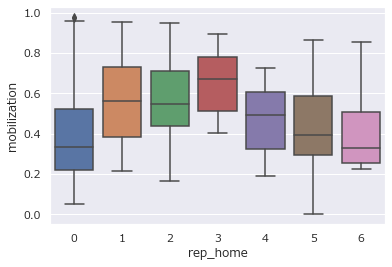

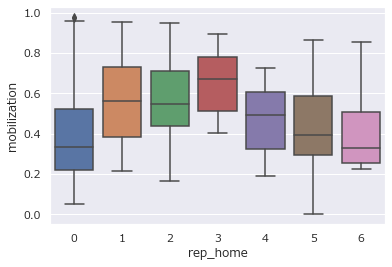

In [42]:
sns.boxplot(x="rep_home", y="mobilization", data=train)

<AxesSubplot:xlabel='rep_away', ylabel='mobilization'>

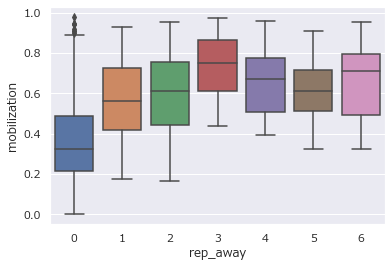

<AxesSubplot:xlabel='rep_away', ylabel='mobilization'>

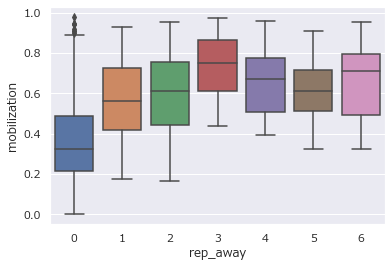

In [43]:
sns.boxplot(x="rep_away", y="mobilization", data=train)

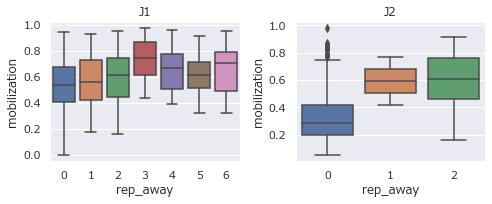

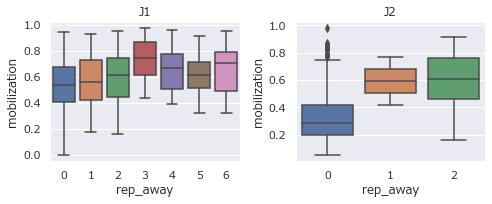

In [44]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
sns.boxplot(x="rep_away", y="mobilization", data=train[train["stage"]=="Ｊ１"], ax=ax[0])
ax[0].set_title("J1")
sns.boxplot(x="rep_away", y="mobilization", data=train[train["stage"]=="Ｊ２"], ax=ax[1])
ax[1].set_title("J2")
plt.tight_layout()

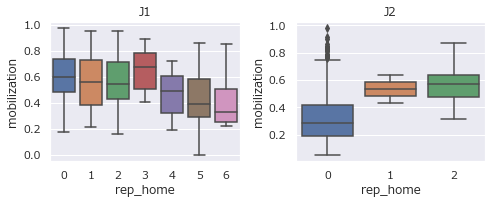

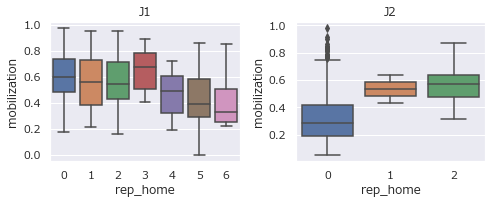

In [45]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
sns.boxplot(x="rep_home", y="mobilization", data=train[train["stage"]=="Ｊ１"], ax=ax[0])
ax[0].set_title("J1")
sns.boxplot(x="rep_home", y="mobilization", data=train[train["stage"]=="Ｊ２"], ax=ax[1])
ax[1].set_title("J2")
plt.tight_layout()

<AxesSubplot:xlabel='WEATHER', ylabel='mobilization'>

<AxesSubplot:xlabel='WEATHER', ylabel='mobilization'>

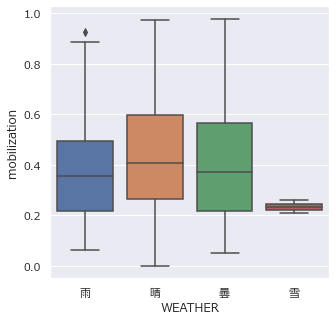

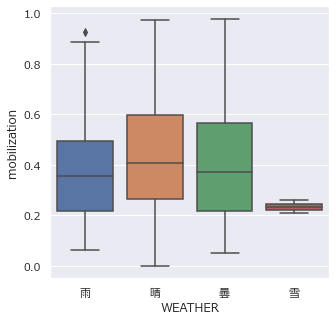

In [46]:
plt.figure(figsize=(5,5))
sns.boxplot(x="WEATHER",y="mobilization",data=train)

<AxesSubplot:xlabel='forme', ylabel='mobilization'>

<AxesSubplot:xlabel='forme', ylabel='mobilization'>

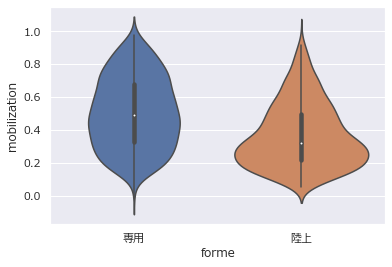

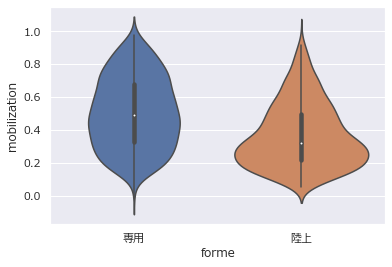

In [47]:
sns.violinplot(x="forme", y="mobilization", data=train)

In [48]:
# 結合、但し、trainでyが0以上のものだけを選択
dat = pd.concat([train[train["y"]>0],test],sort=False)

select_cols = ["WEATHER","MONTH","WEEK","home","away","capa","tv_num","stage","train","week_timezone",'distance_km',"rep_away","forme","referee_rank"]
datX = pd.get_dummies(dat[select_cols],drop_first=True)

# datXにおいてtrainフラグが1のものをtrainXとする。その後、trainフラグを削除
trainX = datX[datX["train"]==1]
trainX = trainX.drop(columns="train")

# datXにおいてtrainフラグが0のものをtestXとする。その後、trainフラグを削除
testX = datX[datX["train"]==0]
testX = testX.drop(columns="train")

y = train[train["mobilization"]>0]["mobilization"]

trainX.head()

,MONTH,capa,tv_num,distance_km,rep_away,referee_rank,WEATHER_曇,WEATHER_雨,WEATHER_雪,WEEK_日,WEEK_月,WEEK_木,WEEK_水,WEEK_火,WEEK_金,home_アルビレックス新潟,home_カターレ富山,home_カマタマーレ讃岐,home_ガイナーレ鳥取,home_ガンバ大阪,home_ギラヴァンツ北九州,home_コンサドーレ札幌,home_サガン鳥栖,home_サンフレッチェ広島,home_ザスパクサツ群馬,...,away_横浜ＦＣ,away_水戸ホーリーホック,away_浦和レッズ,away_清水エスパルス,away_湘南ベルマーレ,away_鹿島アントラーズ,away_ＦＣ岐阜,away_ＦＣ東京,away_ＦＣ町田ゼルビア,away_Ｖ・ファーレン長崎,stage_Ｊ２,week_timezone_土noon,week_timezone_日night,week_timezone_日noon,week_timezone_月night,week_timezone_月noon,week_timezone_木night,week_timezone_木noon,week_timezone_水night,week_timezone_水noon,week_timezone_火night,week_timezone_火noon,week_timezone_金night,week_timezone_金noon,forme_陸上
0,3,19694,4,259.062330,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,40000,4,120.059935,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,21000,4,38.255308,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,50000,4,685.986038,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3,39232,4,966.885906,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


,MONTH,capa,tv_num,distance_km,rep_away,referee_rank,WEATHER_曇,WEATHER_雨,WEATHER_雪,WEEK_日,WEEK_月,WEEK_木,WEEK_水,WEEK_火,WEEK_金,home_アルビレックス新潟,home_カターレ富山,home_カマタマーレ讃岐,home_ガイナーレ鳥取,home_ガンバ大阪,home_ギラヴァンツ北九州,home_コンサドーレ札幌,home_サガン鳥栖,home_サンフレッチェ広島,home_ザスパクサツ群馬,...,away_横浜ＦＣ,away_水戸ホーリーホック,away_浦和レッズ,away_清水エスパルス,away_湘南ベルマーレ,away_鹿島アントラーズ,away_ＦＣ岐阜,away_ＦＣ東京,away_ＦＣ町田ゼルビア,away_Ｖ・ファーレン長崎,stage_Ｊ２,week_timezone_土noon,week_timezone_日night,week_timezone_日noon,week_timezone_月night,week_timezone_月noon,week_timezone_木night,week_timezone_木noon,week_timezone_水night,week_timezone_水noon,week_timezone_火night,week_timezone_火noon,week_timezone_金night,week_timezone_金noon,forme_陸上
0,3,19694,4,259.062330,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,40000,4,120.059935,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,21000,4,38.255308,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,50000,4,685.986038,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3,39232,4,966.885906,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
y.head()

0    0.92668
1    0.60790
2    0.81267
3    0.59206
4    0.64623
Name: mobilization, dtype: float64

0    0.92668
1    0.60790
2    0.81267
3    0.59206
4    0.64623
Name: mobilization, dtype: float64

In [50]:
trainX.shape

(1952, 114)

(1952, 114)

In [51]:
y.shape

(1952,)

(1952,)

In [52]:
df_train, df_val =train_test_split(trainX, test_size=0.4)

In [53]:
train_y = y
train_x = trainX

In [54]:
val_y = y
val_x = trainX
trains = lgb.Dataset(train_x, train_y)
valids = lgb.Dataset(val_x, val_y)


In [55]:
params = {
    "objective": "regression",
    "metrics": "rmse"
}



In [56]:
model = lgb.train(params, trains, valid_sets=valids, num_boost_round=1000, early_stopping_rounds=999)

C:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1952, number of used features: 105
[LightGBM] [Info] Start training from score 0.420898
[1]	valid_0's rmse: 0.199446
Training until validation scores don't improve for 999 rounds
[2]	valid_0's rmse: 0.186853
[3]	valid_0's rmse: 0.175896
[4]	valid_0's rmse: 0.166288
[5]	valid_0's rmse: 0.158186
[6]	valid_0's rmse: 0.150949
[7]	valid_0's rmse: 0.144653
[8]	valid_0's rmse: 0.138868
[9]	valid_0's rmse: 0.133984
[10]	valid_0's rmse: 0.129396
[11]	valid_0's rmse: 0.125387
[12]	valid_0's rmse: 0.121923
[13]	valid_0's rmse: 0.118908
[14]	valid_0's rmse: 0.116374
[15]	valid_0's rmse: 0.113884
[16]	valid_0's rmse: 0.111805
[17]	valid_0's rmse: 0.109542
[18]	valid_0's rmse: 0.107786
[19]	valid_0's rmse: 0.105841
[20]	valid_0's rmse: 0.104147
[21

[100]	valid_0's rmse: 0.0657329
[101]	valid_0's rmse: 0.0655025
[102]	valid_0's rmse: 0.0653167
[103]	valid_0's rmse: 0.0651578
[104]	valid_0's rmse: 0.0649206
[105]	valid_0's rmse: 0.0647108
[106]	valid_0's rmse: 0.0644869
[107]	valid_0's rmse: 0.0642908
[108]	valid_0's rmse: 0.0640899
[109]	valid_0's rmse: 0.0639264
[110]	valid_0's rmse: 0.0637595
[111]	valid_0's rmse: 0.0635522
[112]	valid_0's rmse: 0.0633539
[113]	valid_0's rmse: 0.0631157
[114]	valid_0's rmse: 0.0629273
[115]	valid_0's rmse: 0.0627551
[116]	valid_0's rmse: 0.0626081
[117]	valid_0's rmse: 0.0623913
[118]	valid_0's rmse: 0.0621949
[119]	valid_0's rmse: 0.0619979
[120]	valid_0's rmse: 0.061802
[121]	valid_0's rmse: 0.0616751
[122]	valid_0's rmse: 0.061477
[123]	valid_0's rmse: 0.0613312
[124]	valid_0's rmse: 0.0611564
[125]	valid_0's rmse: 0.0609748
[126]	valid_0's rmse: 0.0607894
[127]	valid_0's rmse: 0.0606117
[128]	valid_0's rmse: 0.0603703
[129]	valid_0's rmse: 0.0601879
[130]	valid_0's rmse: 0.0600418
[131]	vali

[324]	valid_0's rmse: 0.039695
[325]	valid_0's rmse: 0.0396342
[326]	valid_0's rmse: 0.0395497
[327]	valid_0's rmse: 0.0394741
[328]	valid_0's rmse: 0.039417
[329]	valid_0's rmse: 0.0393201
[330]	valid_0's rmse: 0.039249
[331]	valid_0's rmse: 0.0391925
[332]	valid_0's rmse: 0.0391335
[333]	valid_0's rmse: 0.0390472
[334]	valid_0's rmse: 0.038993
[335]	valid_0's rmse: 0.0389308
[336]	valid_0's rmse: 0.0388502
[337]	valid_0's rmse: 0.038767
[338]	valid_0's rmse: 0.0386925
[339]	valid_0's rmse: 0.0386406
[340]	valid_0's rmse: 0.0385648
[341]	valid_0's rmse: 0.0384782
[342]	valid_0's rmse: 0.0384335
[343]	valid_0's rmse: 0.0383452
[344]	valid_0's rmse: 0.0382799
[345]	valid_0's rmse: 0.0382119
[346]	valid_0's rmse: 0.0381434
[347]	valid_0's rmse: 0.0380924
[348]	valid_0's rmse: 0.0380417
[349]	valid_0's rmse: 0.0379627
[350]	valid_0's rmse: 0.0378882
[351]	valid_0's rmse: 0.0378016
[352]	valid_0's rmse: 0.0377275
[353]	valid_0's rmse: 0.0376757
[354]	valid_0's rmse: 0.0375931
[355]	valid_0


[438]	valid_0's rmse: 0.0324948
[439]	valid_0's rmse: 0.0324384
[440]	valid_0's rmse: 0.0323812
[441]	valid_0's rmse: 0.0323266
[442]	valid_0's rmse: 0.0322785
[443]	valid_0's rmse: 0.0322256
[444]	valid_0's rmse: 0.0321637
[445]	valid_0's rmse: 0.0321082
[446]	valid_0's rmse: 0.0320649
[447]	valid_0's rmse: 0.0319975
[448]	valid_0's rmse: 0.0319545
[449]	valid_0's rmse: 0.031903
[450]	valid_0's rmse: 0.0318514
[451]	valid_0's rmse: 0.0318066
[452]	valid_0's rmse: 0.0317532
[453]	valid_0's rmse: 0.0316887
[454]	valid_0's rmse: 0.031647
[455]	valid_0's rmse: 0.0316089
[456]	valid_0's rmse: 0.0315663
[457]	valid_0's rmse: 0.0314968
[458]	valid_0's rmse: 0.0314297
[459]	valid_0's rmse: 0.0313878
[460]	valid_0's rmse: 0.0313224
[461]	valid_0's rmse: 0.0312784
[462]	valid_0's rmse: 0.0312325
[463]	valid_0's rmse: 0.0311736
[464]	valid_0's rmse: 0.031112
[465]	valid_0's rmse: 0.0310666
[466]	valid_0's rmse: 0.0310245
[467]	valid_0's rmse: 0.030974
[468]	valid_0's rmse: 0.0309104
[469]	valid

[648]	valid_0's rmse: 0.023361
[649]	valid_0's rmse: 0.0233186
[650]	valid_0's rmse: 0.02328
[651]	valid_0's rmse: 0.0232445
[652]	valid_0's rmse: 0.0232059
[653]	valid_0's rmse: 0.0231764
[654]	valid_0's rmse: 0.02314
[655]	valid_0's rmse: 0.0230968
[656]	valid_0's rmse: 0.0230568
[657]	valid_0's rmse: 0.0230242
[658]	valid_0's rmse: 0.0229794
[659]	valid_0's rmse: 0.0229408
[660]	valid_0's rmse: 0.022902
[661]	valid_0's rmse: 0.0228686
[662]	valid_0's rmse: 0.0228395
[663]	valid_0's rmse: 0.0228088
[664]	valid_0's rmse: 0.0227796
[665]	valid_0's rmse: 0.0227502
[666]	valid_0's rmse: 0.0227044
[667]	valid_0's rmse: 0.0226671
[668]	valid_0's rmse: 0.0226371
[669]	valid_0's rmse: 0.0225897
[670]	valid_0's rmse: 0.0225507
[671]	valid_0's rmse: 0.0225332
[672]	valid_0's rmse: 0.0224918
[673]	valid_0's rmse: 0.0224682
[674]	valid_0's rmse: 0.0224456
[675]	valid_0's rmse: 0.0224097
[676]	valid_0's rmse: 0.0223838
[677]	valid_0's rmse: 0.0223574
[678]	valid_0's rmse: 0.0223369
[679]	valid_0'

[812]	valid_0's rmse: 0.0184421[752]	valid_0's rmse: 0.020089
[753]	valid_0's rmse: 0.0200616
[754]	valid_0's rmse: 0.0200411
[755]	valid_0's rmse: 0.0200172
[756]	valid_0's rmse: 0.0199953
[757]	valid_0's rmse: 0.0199702
[758]	valid_0's rmse: 0.0199468
[759]	valid_0's rmse: 0.0199226
[760]	valid_0's rmse: 0.0198905
[761]	valid_0's rmse: 0.0198708
[762]	valid_0's rmse: 0.0198554
[763]	valid_0's rmse: 0.0198219
[764]	valid_0's rmse: 0.0197867
[765]	valid_0's rmse: 0.019756
[766]	valid_0's rmse: 0.0197125
[767]	valid_0's rmse: 0.0196797
[768]	valid_0's rmse: 0.0196487
[769]	valid_0's rmse: 0.019613
[770]	valid_0's rmse: 0.0195938
[771]	valid_0's rmse: 0.0195685
[772]	valid_0's rmse: 0.0195435
[773]	valid_0's rmse: 0.0195274
[774]	valid_0's rmse: 0.0195009
[775]	valid_0's rmse: 0.0194726
[776]	valid_0's rmse: 0.019449
[777]	valid_0's rmse: 0.0194255
[778]	valid_0's rmse: 0.0193959
[779]	valid_0's rmse: 0.0193725
[780]	valid_0's rmse: 0.0193519
[781]	valid_0's rmse: 0.0193181
[782]	valid_0

[901]	valid_0's rmse: 0.0163307
[902]	valid_0's rmse: 0.0163104
[903]	valid_0's rmse: 0.0162891
[904]	valid_0's rmse: 0.0162686
[905]	valid_0's rmse: 0.0162527
[906]	valid_0's rmse: 0.0162314
[907]	valid_0's rmse: 0.0162071
[908]	valid_0's rmse: 0.0161838
[909]	valid_0's rmse: 0.0161536
[910]	valid_0's rmse: 0.0161319
[911]	valid_0's rmse: 0.0161078
[912]	valid_0's rmse: 0.0160843
[913]	valid_0's rmse: 0.0160597
[914]	valid_0's rmse: 0.0160461
[915]	valid_0's rmse: 0.0160254
[916]	valid_0's rmse: 0.015999
[917]	valid_0's rmse: 0.0159816
[918]	valid_0's rmse: 0.0159566
[919]	valid_0's rmse: 0.0159328
[920]	valid_0's rmse: 0.0159069
[921]	valid_0's rmse: 0.0158839
[922]	valid_0's rmse: 0.0158565
[923]	valid_0's rmse: 0.0158406
[924]	valid_0's rmse: 0.0158182
[925]	valid_0's rmse: 0.0157993
[926]	valid_0's rmse: 0.0157758
[927]	valid_0's rmse: 0.0157597
[928]	valid_0's rmse: 0.0157379
[929]	valid_0's rmse: 0.0157243
[930]	valid_0's rmse: 0.015701
[931]	valid_0's rmse: 0.0156867
[932]	vali

In [57]:
from sklearn.metrics import mean_squared_error

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1952, number of used features: 105
[LightGBM] [Info] Start training from score 0.420898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1952, number of used features: 105
[LightGBM] [Info] Start training from score 0.420898


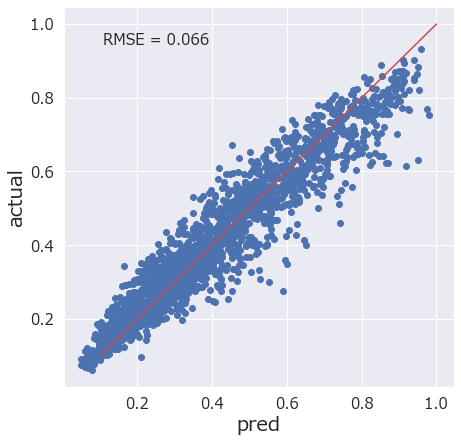

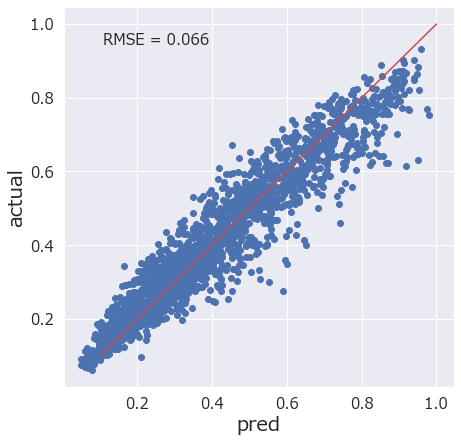

In [58]:
# 訓練データから回帰モデルを作る
gbm = lgb.train(params, trains)
# テストデータを用いて予測精度を確認する
test_predicted = gbm.predict(val_x)
predicted_df = pd.concat([val_y.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
predicted_df.columns = ['true', 'predicted']
# 予測値を図で確認する関数の定義
def Prediction_accuracy(predicted_df):
    RMSE = np.sqrt(mean_squared_error(predicted_df['true'], predicted_df['predicted']))
    plt.figure(figsize = (7,7))
    ax = plt.subplot(111)
    ax.scatter('true', 'predicted', data = predicted_df)
    ax.set_xlabel('pred', fontsize = 20)
    ax.set_ylabel('actual', fontsize = 20)
    plt.tick_params(labelsize = 15)
    x = np.linspace(0.1, 1)
    y = x
    ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE,3))),transform = ax.transAxes, fontsize = 15)
# 予測値を図で確認する
Prediction_accuracy(predicted_df)

In [59]:
predict = model.predict(testX)


sample[1] = predict*testX["capa"]
sample.to_csv("sample102.csv",index=None,header=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

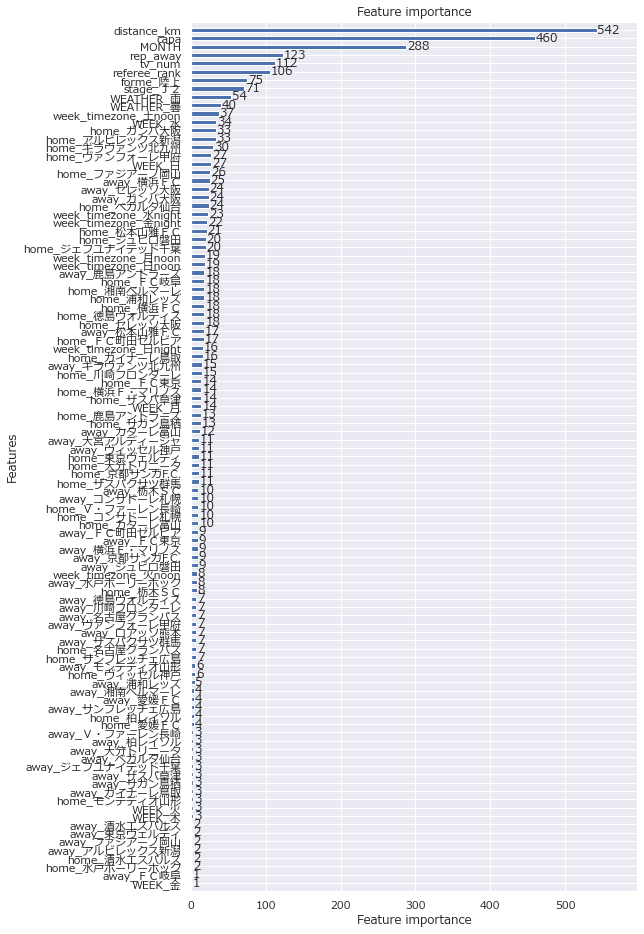

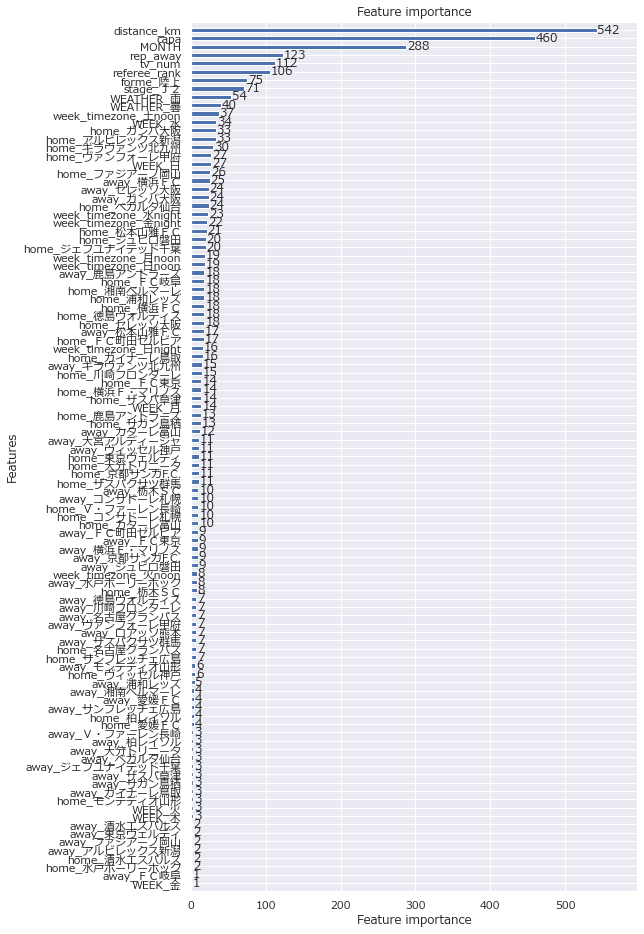

In [60]:
lgb.plot_importance(gbm, height = 0.5, figsize = (8,16))

In [61]:
tmp = train[train["y"]>0]


tmp["pred"] = model.predict(trainX)
tmp["res"] = tmp["y"] - tmp["pred"]*train["capa"]
tmp.sort_values(by="res")[["res","y","capa","mobilization","pred","year","stage","match","gameday","time","home","away","tv","WEATHER","referee_rank"]].head(10)

C:\Users\Master\AppData\Local\Temp/ipykernel_15036/3718745159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["pred"] = model.predict(trainX)
C:\Users\Master\AppData\Local\Temp/ipykernel_15036/3718745159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["res"] = tmp["y"] - tmp["pred"]*train["capa"]
C:\Users\Master\AppData\Local\Temp/ipykernel_15036/3718745159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,res,y,capa,mobilization,pred,year,stage,match,gameday,time,home,away,tv,WEATHER,referee_rank
1587,-2504.782355,14165,49970,0.28347,0.333596,2014,Ｊ１,第６節第１日,04/06(日),16:04,ＦＣ東京,サガン鳥栖,スカパー！／スカパー！プレミアムサービス／ＴＯＫＹＯ ＭＸ,曇,3
99,-2339.632553,25241,72327,0.34898,0.381332,2012,Ｊ１,第１２節第１日,05/19(土),14:03,横浜Ｆ・マリノス,ガンバ大阪,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）,晴,1
208,-2052.918225,39814,63700,0.62502,0.657251,2012,Ｊ１,第２４節第１日,09/01(土),18:03,浦和レッズ,大宮アルディージャ,スカパー／ｅ２／スカパー光,晴,1
96,-1968.022716,31818,63700,0.49950,0.530393,2012,Ｊ１,第１１節第１日,05/12(土),16:04,浦和レッズ,アルビレックス新潟,スカパー／ｅ２／スカパー光,晴,1
29,-1845.965545,25743,63700,0.40413,0.433108,2012,Ｊ１,第４節第１日,03/31(土),15:03,浦和レッズ,川崎フロンターレ,スカパー／ｅ２／スカパー光／テレ玉,雨,1
1642,-1565.008438,9515,50000,0.19030,0.221600,2014,Ｊ１,第１２節第２日,07/15(火),19:04,サンフレッチェ広島,横浜Ｆ・マリノス,スカパー！／スカパー！プレミアムサービス,晴,1
244,-1546.047565,36412,72327,0.50344,0.524812,2012,Ｊ１,第２８節第１日,10/06(土),14:04,横浜Ｆ・マリノス,サンフレッチェ広島,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,晴,1
791,-1425.354386,13702,47816,0.28656,0.316366,2013,Ｊ１,第３節第１日,03/16(土),15:04,セレッソ大阪,ＦＣ東京,スカパー！／スカパー！プレミアムサービス,晴,1
1118,-1390.963929,9038,20396,0.44313,0.511324,2013,Ｊ２,第５節第１日,03/24(日),13:03,松本山雅ＦＣ,Ｖ・ファーレン長崎,スカパー！／スカパー！プレミアムサービス,晴,1
28,-1388.973121,16229,49970,0.32477,0.352571,2012,Ｊ１,第４節第１日,03/31(土),14:04,ＦＣ東京,サンフレッチェ広島,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＴＯＫＹＯ ＭＸ（録）,雨,1


,res,y,capa,mobilization,pred,year,stage,match,gameday,time,home,away,tv,WEATHER,referee_rank
1587,-2504.782355,14165,49970,0.28347,0.333596,2014,Ｊ１,第６節第１日,04/06(日),16:04,ＦＣ東京,サガン鳥栖,スカパー！／スカパー！プレミアムサービス／ＴＯＫＹＯ ＭＸ,曇,3
99,-2339.632553,25241,72327,0.34898,0.381332,2012,Ｊ１,第１２節第１日,05/19(土),14:03,横浜Ｆ・マリノス,ガンバ大阪,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）,晴,1
208,-2052.918225,39814,63700,0.62502,0.657251,2012,Ｊ１,第２４節第１日,09/01(土),18:03,浦和レッズ,大宮アルディージャ,スカパー／ｅ２／スカパー光,晴,1
96,-1968.022716,31818,63700,0.49950,0.530393,2012,Ｊ１,第１１節第１日,05/12(土),16:04,浦和レッズ,アルビレックス新潟,スカパー／ｅ２／スカパー光,晴,1
29,-1845.965545,25743,63700,0.40413,0.433108,2012,Ｊ１,第４節第１日,03/31(土),15:03,浦和レッズ,川崎フロンターレ,スカパー／ｅ２／スカパー光／テレ玉,雨,1
1642,-1565.008438,9515,50000,0.19030,0.221600,2014,Ｊ１,第１２節第２日,07/15(火),19:04,サンフレッチェ広島,横浜Ｆ・マリノス,スカパー！／スカパー！プレミアムサービス,晴,1
244,-1546.047565,36412,72327,0.50344,0.524812,2012,Ｊ１,第２８節第１日,10/06(土),14:04,横浜Ｆ・マリノス,サンフレッチェ広島,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,晴,1
791,-1425.354386,13702,47816,0.28656,0.316366,2013,Ｊ１,第３節第１日,03/16(土),15:04,セレッソ大阪,ＦＣ東京,スカパー！／スカパー！プレミアムサービス,晴,1
1118,-1390.963929,9038,20396,0.44313,0.511324,2013,Ｊ２,第５節第１日,03/24(日),13:03,松本山雅ＦＣ,Ｖ・ファーレン長崎,スカパー！／スカパー！プレミアムサービス,晴,1
28,-1388.973121,16229,49970,0.32477,0.352571,2012,Ｊ１,第４節第１日,03/31(土),14:04,ＦＣ東京,サンフレッチェ広島,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＴＯＫＹＯ ＭＸ（録）,雨,1


In [62]:
tmp.sort_values(by="res",ascending=False)[["res","y","capa","mobilization","pred","year","stage","match","gameday","time","home","away","tv","WEATHER","referee_rank"]].head(10)

,res,y,capa,mobilization,pred,year,stage,match,gameday,time,home,away,tv,WEATHER,referee_rank
1059,3302.708492,62632,72327,0.86596,0.820292,2013,Ｊ１,第３３節第１日,11/30(土),14:04,横浜Ｆ・マリノス,アルビレックス新潟,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合,晴,1
107,2912.271253,25803,49970,0.51637,0.458089,2012,Ｊ１,第１２節第２日,05/20(日),15:04,ＦＣ東京,サガン鳥栖,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）,曇,3
1630,2708.166060,35550,72327,0.49152,0.454074,2014,Ｊ１,第１１節第１日,05/03(土・祝),14:04,横浜Ｆ・マリノス,ガンバ大阪,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合,晴,2
1078,1884.972587,10447,49970,0.20907,0.171343,2013,Ｊ２,第１節第１日,03/03(日),14:04,東京ヴェルディ,アビスパ福岡,スカパー！／スカパー！プレミアムサービス,曇,1
231,1855.248548,34822,49970,0.69686,0.659731,2012,Ｊ１,第２６節第１日,09/22(土・祝),19:04,ＦＣ東京,川崎フロンターレ,スカパー／ｅ２／スカパー光,曇,1
206,1785.104886,23656,50000,0.47312,0.437418,2012,Ｊ１,第２３節第１日,08/25(土),19:05,サンフレッチェ広島,ＦＣ東京,スカパー／ｅ２／スカパー光,晴,2
1670,1782.950442,20616,30132,0.68419,0.625018,2014,Ｊ１,第１５節第１日,07/19(土),19:04,ヴィッセル神戸,サガン鳥栖,スカパー！／スカパー！プレミアムサービス,晴,1
953,1778.317502,22530,24490,0.91997,0.847353,2013,Ｊ１,第２１節第１日,08/17(土),19:03,サガン鳥栖,大宮アルディージャ,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,晴,2
1545,1758.197764,16176,50000,0.32352,0.288356,2014,Ｊ１,第２節第１日,03/08(土),12:34,サンフレッチェ広島,川崎フロンターレ,スカパー！／スカパー！プレミアムサービス,晴,1
1690,1497.799088,11069,20000,0.55345,0.478560,2014,Ｊ２,第１節第１日,03/02(日),13:05,ＦＣ岐阜,カマタマーレ讃岐,スカパー！／スカパー！プレミアムサービス／岐阜放送（録）,晴,3


,res,y,capa,mobilization,pred,year,stage,match,gameday,time,home,away,tv,WEATHER,referee_rank
1059,3302.708492,62632,72327,0.86596,0.820292,2013,Ｊ１,第３３節第１日,11/30(土),14:04,横浜Ｆ・マリノス,アルビレックス新潟,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合,晴,1
107,2912.271253,25803,49970,0.51637,0.458089,2012,Ｊ１,第１２節第２日,05/20(日),15:04,ＦＣ東京,サガン鳥栖,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）,曇,3
1630,2708.166060,35550,72327,0.49152,0.454074,2014,Ｊ１,第１１節第１日,05/03(土・祝),14:04,横浜Ｆ・マリノス,ガンバ大阪,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合,晴,2
1078,1884.972587,10447,49970,0.20907,0.171343,2013,Ｊ２,第１節第１日,03/03(日),14:04,東京ヴェルディ,アビスパ福岡,スカパー！／スカパー！プレミアムサービス,曇,1
231,1855.248548,34822,49970,0.69686,0.659731,2012,Ｊ１,第２６節第１日,09/22(土・祝),19:04,ＦＣ東京,川崎フロンターレ,スカパー／ｅ２／スカパー光,曇,1
206,1785.104886,23656,50000,0.47312,0.437418,2012,Ｊ１,第２３節第１日,08/25(土),19:05,サンフレッチェ広島,ＦＣ東京,スカパー／ｅ２／スカパー光,晴,2
1670,1782.950442,20616,30132,0.68419,0.625018,2014,Ｊ１,第１５節第１日,07/19(土),19:04,ヴィッセル神戸,サガン鳥栖,スカパー！／スカパー！プレミアムサービス,晴,1
953,1778.317502,22530,24490,0.91997,0.847353,2013,Ｊ１,第２１節第１日,08/17(土),19:03,サガン鳥栖,大宮アルディージャ,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,晴,2
1545,1758.197764,16176,50000,0.32352,0.288356,2014,Ｊ１,第２節第１日,03/08(土),12:34,サンフレッチェ広島,川崎フロンターレ,スカパー！／スカパー！プレミアムサービス,晴,1
1690,1497.799088,11069,20000,0.55345,0.478560,2014,Ｊ２,第１節第１日,03/02(日),13:05,ＦＣ岐阜,カマタマーレ讃岐,スカパー！／スカパー！プレミアムサービス／岐阜放送（録）,晴,3


In [63]:
model3 = LR()

In [64]:
model3.fit(trainX,y)

LinearRegression()

LinearRegression()

In [65]:
pred_LR3 = model3.predict(testX)

In [66]:
pred = pd.DataFrame({"LR":pred_LR3,"gbm":predict})
pred

,LR,gbm
0,0.759123,0.838089
1,0.430878,0.549076
2,0.578595,0.487822
3,0.826074,0.819235
4,0.718303,0.639971
...,...,...
308,0.200358,0.215251
309,0.459419,0.599622
310,0.214559,0.191994
311,0.355295,0.509556


,LR,gbm
0,0.759123,0.838089
1,0.430878,0.549076
2,0.578595,0.487822
3,0.826074,0.819235
4,0.718303,0.639971
...,...,...
308,0.200358,0.215251
309,0.459419,0.599622
310,0.214559,0.191994
311,0.355295,0.509556


In [67]:
pred["mean"] = pred.mean(axis=1)
pred.head()

,LR,gbm,mean
0,0.759123,0.838089,0.798606
1,0.430878,0.549076,0.489977
2,0.578595,0.487822,0.533209
3,0.826074,0.819235,0.822655
4,0.718303,0.639971,0.679137


,LR,gbm,mean
0,0.759123,0.838089,0.798606
1,0.430878,0.549076,0.489977
2,0.578595,0.487822,0.533209
3,0.826074,0.819235,0.822655
4,0.718303,0.639971,0.679137


In [68]:
sample[1] = pred["mean"]*testX["capa"]
sample.to_csv("sample103.csv",index=None,header=None)